In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.optimize import curve_fit
from sklearn import decomposition, manifold, preprocessing, cluster
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from scipy.spatial import KDTree, distance
import umap
import os

def readSWC(swc_path, mode='simple'):
    n_skip = 0
    with open(swc_path, "r") as f:
        for line in f.readlines():
            line = line.strip()
            if line.startswith("#"):
                n_skip += 1
            else:
                break
    names = ["##n", "type", "x", "y", "z", "r", "parent"]
    used_cols = [0, 1, 2, 3, 4, 5, 6]
    if mode == 'simple':
        pass
    df = pd.read_csv(swc_path, index_col=0, skiprows=n_skip, sep=" ",
                     usecols=used_cols,
                     names=names
                     )

    return df

def hex2rgb(hexcolor):
    if type(hexcolor) is str:
        hexcolor = hexcolor.replace('#', '0x')
        hexcolor = (int(hexcolor, base=16))
    rgb = [(hexcolor >> 16) & 0xff,
      (hexcolor >> 8) & 0xff,
      hexcolor & 0xff
     ]
    return rgb

def genObj(df, output_p):
    objLines = []
    NeuronHash = {}
    for k,i in enumerate(df.index):
        NeuronHash[i] = k
        line = 'v ' + str(df.loc[i,'x']) + ' ' + str(df.loc[i,'y']) + ' ' + str(df.loc[i,'z']) + '\n'
        objLines.append(line)
    for k,i in enumerate(df.index):
        p = df.loc[i,'parent']
        if p not in NeuronHash.keys():
            continue
        line = 'l ' + str(k + 1) + ' ' + str(NeuronHash[p] + 1) + '\n'
        objLines.append(line)

    with open(output_p, 'w') as f:
        f.writelines(objLines)

In [2]:
ori_soma_feature = pd.read_csv('../../data/155k_DEN_soma_feature.csv', 
                           sep=',', index_col=0)
ori_soma_feature.index = [i.split('.swc')[0] for i in ori_soma_feature.index]
ori_soma_feature['x'] = ori_soma_feature['x'] / 25
ori_soma_feature['y'] = ori_soma_feature['y'] / 25
ori_soma_feature['z'] = ori_soma_feature['z'] / 25
for i in (ori_soma_feature.index):
    if ori_soma_feature.loc[i, 'z'] < 456 / 2:
        ori_soma_feature.loc[i, 'z'] = 456 - ori_soma_feature.loc[i, 'z']
ori_soma_feature

,x,y,z,source_region,source_region_withCorticalRegion
SEU-ALLEN_local_15257_10001_19868_8155_CCFv3,451.504,146.713,233.47500,fiber tracts,arb
SEU-ALLEN_local_15257_10008_10862_6996_CCFv3,385.001,150.561,360.70904,ENTm,ENTm5
SEU-ALLEN_local_15257_10012_10978_7039_CCFv3,387.307,150.165,359.40000,ENTm,ENTm5
SEU-ALLEN_local_15257_10020_17924_8129_CCFv3,450.710,145.238,254.59100,fiber tracts,arb
SEU-ALLEN_local_15257_10028_28224_6732_CCFv3,371.957,159.326,361.03200,SUB,SUB
...,...,...,...,...,...
SEU-ALLEN_local_236174_7626_18076_3068_CCFv3,159.942,76.319,232.59300,ACAd,ACAd1
SEU-ALLEN_local_236174_8122_17844_3762_CCFv3,193.699,80.697,235.50900,ACAd,ACAd2/3
SEU-ALLEN_local_236174_8813_17916_4826_CCFv3,239.607,85.757,236.06800,ACAv,ACAv2/3
SEU-ALLEN_local_236174_9571_7846_6146_CCFv3,297.035,126.673,384.21200,AUDd,AUDd6a


In [3]:
ori_soma_feature['source_region'].value_counts()

source_region
CP              21802
MOB             16644
fiber tracts    10526
IC               6709
AN               4770
                ...  
AT                  1
LC                  1
SLD                 1
ADP                 1
STN                 1
Name: count, Length: 288, dtype: int64

In [4]:
soma_feature = pd.DataFrame()
ct = ori_soma_feature['source_region'].value_counts()
# ct = ct[ct>100]
ct = ct[['CA1', ]]

for i in ct.index:
    soma_feature = pd.concat([soma_feature, 
                              ori_soma_feature[ori_soma_feature['source_region']==i]], 
                             axis=0)

soma_feature

,x,y,z,source_region,source_region_withCorticalRegion
SEU-ALLEN_local_15257_11828_9319_6464_CCFv3,350.87900,119.023,382.147,CA1,CA1
SEU-ALLEN_local_15257_12664_10213_6561_CCFv3,354.43500,104.924,368.520,CA1,CA1
SEU-ALLEN_local_15257_12696_10181_6599_CCFv3,356.41800,103.741,369.152,CA1,CA1
SEU-ALLEN_local_15257_12727_10075_6525_CCFv3,352.20596,103.706,370.922,CA1,CA1
SEU-ALLEN_local_15257_12761_10139_6565_CCFv3,354.33900,102.760,369.913,CA1,CA1
...,...,...,...,...,...
SEU-ALLEN_local_211541_4871_9997_7102_CCFv3,352.39300,175.227,365.120,CA1,CA1
SEU-ALLEN_local_211541_5071_7478_6674_CCFv3,328.62100,218.458,359.391,CA1,CA1
SEU-ALLEN_local_211541_5886_7004_6693_CCFv3,326.03600,231.018,346.088,CA1,CA1
SEU-ALLEN_local_236174_15628_9151_6670_CCFv3,324.80300,225.821,349.086,CA1,CA1


In [5]:
all_cell = pd.read_csv('../../data/ca1_cell_branch_level.csv', sep=',')
all_cell['target_cell'] = all_cell['target_cell'].apply(lambda r: r.split('.swc')[0])

# inter_index = list(set(all_cell['target_cell']).intersection(set(soma_feature.index)))
inter_index = soma_feature.index.intersection(all_cell['target_cell'])

all_cell = all_cell[all_cell['target_cell'].isin(inter_index)]
all_cell = all_cell.set_index('target_cell')
all_cell

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,18
target_cell,,,,,,,,,,,,,,,,,
SEU-ALLEN_local_15257_11828_9319_6464_CCFv3,62,302,93,170,0,0,0,0,0,0,0,0,0,0,0,0,0
SEU-ALLEN_local_15257_12664_10213_6561_CCFv3,73,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
SEU-ALLEN_local_15257_12696_10181_6599_CCFv3,85,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
SEU-ALLEN_local_15257_12727_10075_6525_CCFv3,21,128,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
SEU-ALLEN_local_15257_12761_10139_6565_CCFv3,88,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SEU-ALLEN_local_211541_4871_9997_7102_CCFv3,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
SEU-ALLEN_local_211541_5071_7478_6674_CCFv3,0,50,114,62,49,23,51,38,6,18,0,0,0,0,0,0,0
SEU-ALLEN_local_211541_5886_7004_6693_CCFv3,0,0,16,20,0,0,10,0,0,0,0,0,0,0,0,0,0


In [6]:
soma_feature = soma_feature.loc[inter_index]
soma_feature

,x,y,z,source_region,source_region_withCorticalRegion
SEU-ALLEN_local_15257_11828_9319_6464_CCFv3,350.87900,119.023,382.147,CA1,CA1
SEU-ALLEN_local_15257_12664_10213_6561_CCFv3,354.43500,104.924,368.520,CA1,CA1
SEU-ALLEN_local_15257_12696_10181_6599_CCFv3,356.41800,103.741,369.152,CA1,CA1
SEU-ALLEN_local_15257_12727_10075_6525_CCFv3,352.20596,103.706,370.922,CA1,CA1
SEU-ALLEN_local_15257_12761_10139_6565_CCFv3,354.33900,102.760,369.913,CA1,CA1
...,...,...,...,...,...
SEU-ALLEN_local_211541_4871_9997_7102_CCFv3,352.39300,175.227,365.120,CA1,CA1
SEU-ALLEN_local_211541_5071_7478_6674_CCFv3,328.62100,218.458,359.391,CA1,CA1
SEU-ALLEN_local_211541_5886_7004_6693_CCFv3,326.03600,231.018,346.088,CA1,CA1
SEU-ALLEN_local_236174_15628_9151_6670_CCFv3,324.80300,225.821,349.086,CA1,CA1


In [7]:
df = pd.read_csv('../../data/morpho_feature_usingV3D.csv',
                 sep=',', index_col=0)
df = df.fillna(df.median())
print(np.mean(df['Number of Nodes']) - np.std(df['Number of Nodes']))

df = df.loc[soma_feature.index, 
            # ['Number of Stems', 'Number of Branches', 'Total Length', 'Average Bifurcation Angle Local', 
            #  'Average Bifurcation Angle Remote', 'Hausdorff Dimension']
            ]
df

136.50042662565693


,Number of Nodes,Soma Surface,Number of Stems,Number of Bifurcatons,Number of Branches,Number of Tips,Overall Width,Overall Height,Overall Depth,Average Diameter,...,Total Volume,Max Euclidean Distance,Max Path Distance,Max Branch Order,Average Contraction,Average Fragmentation,Average Parent-daughter Ratio,Average Bifurcation Angle Local,Average Bifurcation Angle Remote,Hausdorff Dimension
SEU-ALLEN_local_15257_11828_9319_6464_CCFv3,931,1809.560,3,11,23,13,145.6090,139.2300,106.4900,4.36562,...,30778.00,99.9481,151.1760,4,0.959913,39.4348,0.956030,41.6182,55.1676,1.028690
SEU-ALLEN_local_15257_12664_10213_6561_CCFv3,102,1180.050,1,0,1,1,18.2598,83.3899,50.1299,3.12530,...,1510.60,98.7615,100.7750,1,0.980015,100.0000,0.963740,58.9138,71.0169,0.983289
SEU-ALLEN_local_15257_12696_10181_6599_CCFv3,100,1451.630,1,0,1,1,26.9102,75.8601,53.4902,3.95422,...,2046.02,96.3544,98.7448,1,0.975792,98.0000,0.962942,58.9138,71.0169,0.985679
SEU-ALLEN_local_15257_12727_10075_6525_CCFv3,223,1441.980,1,1,3,2,82.0000,143.5200,83.7900,2.91988,...,2701.29,99.7442,144.2520,2,0.973462,73.0000,0.989588,43.8063,148.2260,1.040740
SEU-ALLEN_local_15257_12761_10139_6565_CCFv3,103,657.369,1,0,1,1,36.5400,84.3799,38.3398,3.07579,...,1153.57,99.5297,101.7160,1,0.978504,101.0000,1.026210,58.9138,71.0169,0.967055
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SEU-ALLEN_local_211541_4871_9997_7102_CCFv3,598,1017.880,2,10,20,11,80.5693,75.1802,112.0800,4.00940,...,13436.80,99.6081,110.2950,5,0.974099,28.8500,0.989095,55.0734,52.1330,1.075310
SEU-ALLEN_local_211541_5071_7478_6674_CCFv3,2837,4536.460,6,36,76,41,182.2300,173.7500,184.5700,4.27683,...,82114.50,99.9843,132.4830,10,0.952919,36.3158,1.028850,56.6715,55.4485,1.064470
SEU-ALLEN_local_211541_5886_7004_6693_CCFv3,2595,3216.990,4,38,78,41,174.6400,163.1500,184.6000,3.52897,...,55610.90,99.9863,149.5220,8,0.951189,32.2564,0.994013,66.8227,59.4150,1.145690
SEU-ALLEN_local_236174_15628_9151_6670_CCFv3,1943,2123.720,4,24,50,27,68.7500,180.2300,75.6501,5.93306,...,65170.90,97.0733,156.0480,6,0.889982,37.8400,0.967834,71.6669,73.3768,1.147920


In [8]:
my_std = preprocessing.StandardScaler()
my_pca = decomposition.PCA(0.99)
my_umap = umap.UMAP(n_neighbors=5, n_components=2, metric='euclidean',
                min_dist = 1, spread = 2, random_state=1
               )

In [9]:
x_std = my_std.fit_transform(df.values)

In [10]:
x_pca = my_pca.fit_transform(x_std)
print(x_pca.shape)

x_umap = my_umap.fit_transform(x_std)
print(x_umap.shape)

embedding = manifold.MDS(
    n_components=5,
    max_iter=100,
    n_init=4,
    random_state=1,
    normalized_stress=False,
)
X_transformed = embedding.fit_transform(x_pca)

show_df = pd.DataFrame(x_umap, index=df.index, columns=['x_umap', 'y_umap'])
show_df['x_sp'] = X_transformed[:,0]
show_df['y_sp'] = X_transformed[:,1]
show_df['region'] = soma_feature.loc[show_df.index, 'source_region']
show_df['soma_x'] = soma_feature.loc[show_df.index, 'x']
show_df['soma_y'] = soma_feature.loc[show_df.index, 'y']
show_df['soma_z'] = soma_feature.loc[show_df.index, 'z']

z = linkage(X_transformed, method='ward', metric='euclidean')

(2185, 16)


D:\anaconda\envs\xf\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


(2185, 2)


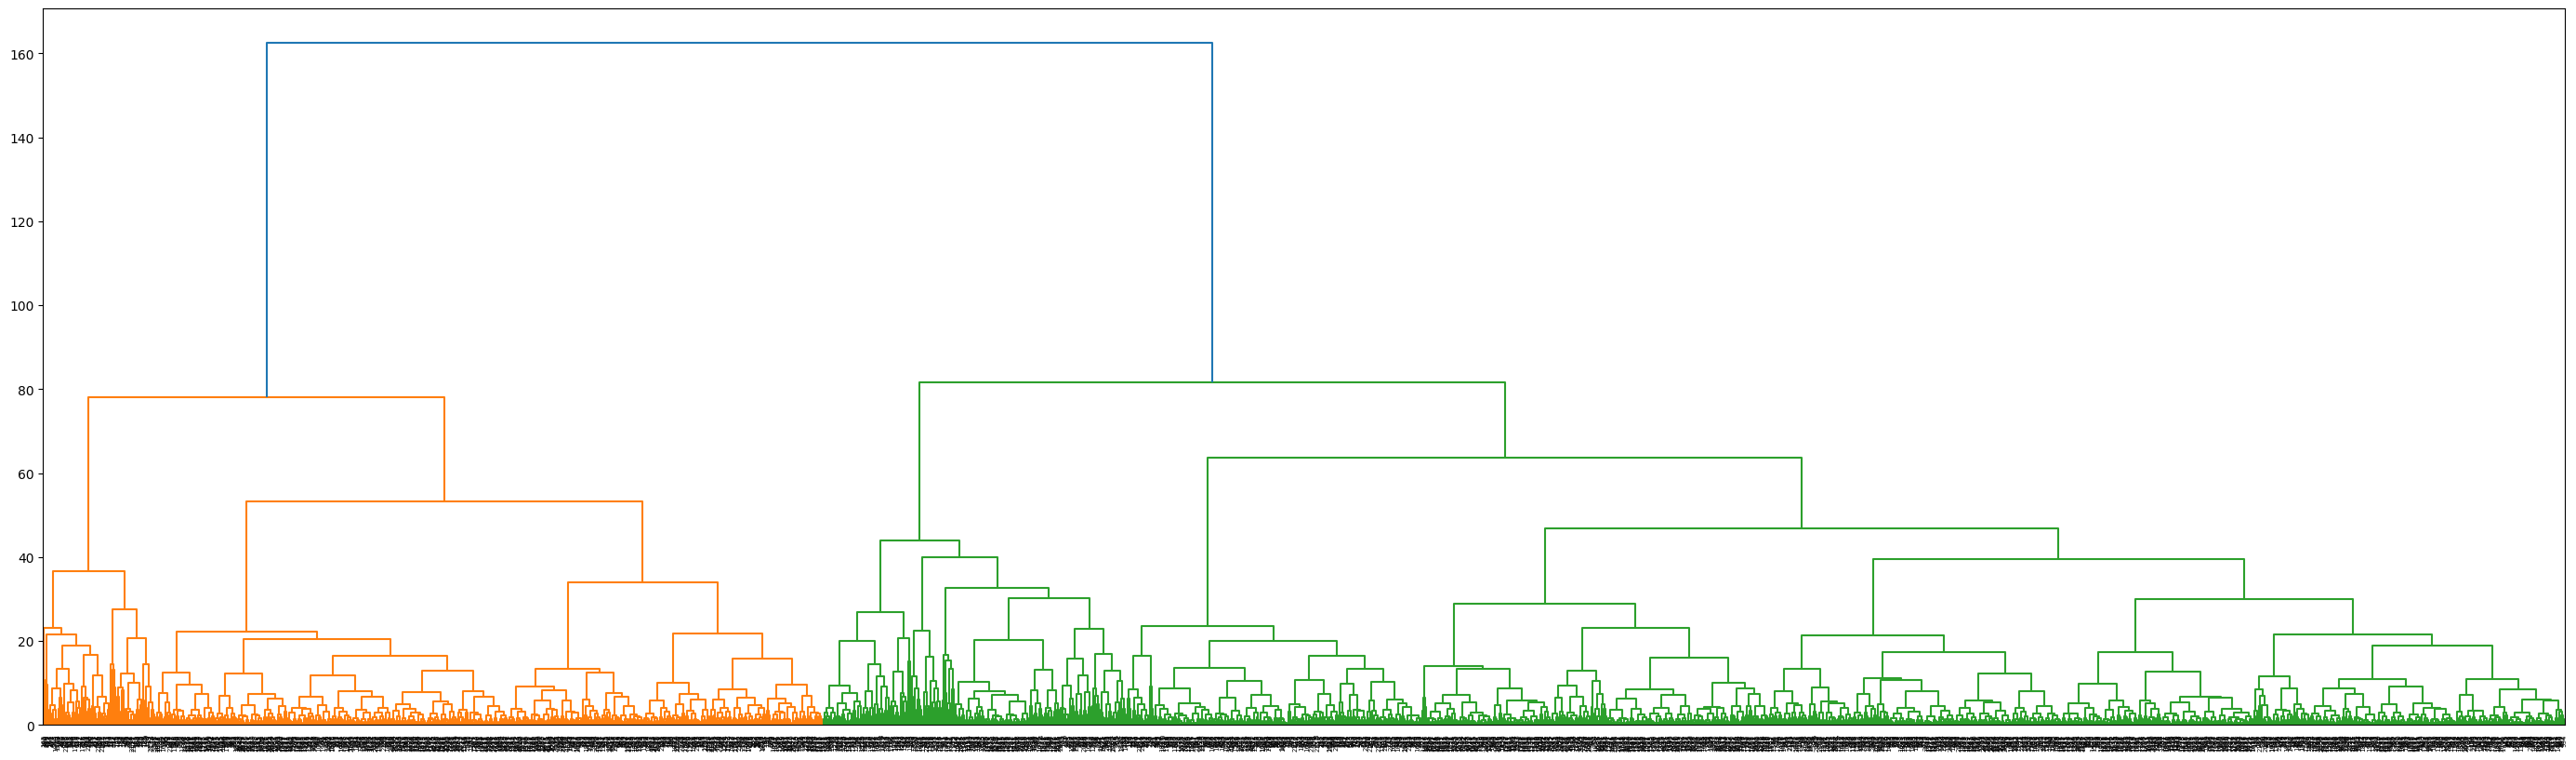

In [11]:
fig = plt.figure(figsize=(35, 10))

dn = dendrogram(z, 
                # color_threshold=0.95
               )
plt.show()

In [12]:
from scipy.cluster.hierarchy import cut_tree
from sklearn.metrics import davies_bouldin_score, calinski_harabasz_score, silhouette_score

max_k = 10
scores = []

for k in range(2, max_k + 1):
    labels = cut_tree(z, k).ravel()
    
    db  = davies_bouldin_score(X_transformed, labels)
    ch  = calinski_harabasz_score(X_transformed, labels)
    sil = silhouette_score(X_transformed, labels)

    scores.append((k, db, ch, sil))
    print(f'k={k:2d}  DB={db:.3f}  CH={ch:.1f}  Sil={sil:.3f}')

k= 2  DB=1.305  CH=850.1  Sil=0.278
k= 3  DB=1.717  CH=589.5  Sil=0.227
k= 4  DB=1.628  CH=517.1  Sil=0.204
k= 5  DB=1.654  CH=462.0  Sil=0.149
k= 6  DB=1.703  CH=416.9  Sil=0.134
k= 7  DB=1.806  CH=381.1  Sil=0.096
k= 8  DB=1.857  CH=354.4  Sil=0.102
k= 9  DB=1.790  CH=331.9  Sil=0.107
k=10  DB=1.773  CH=315.4  Sil=0.098


In [13]:
best_k, _, _, best_sil = max(scores, key=lambda x: x[3])
print(best_k)

2


In [14]:
labels = fcluster(z, t=85, criterion='distance')
print(np.unique(labels))

[1 2]


In [15]:
show_df['label'] = labels

In [16]:
show_df

,x_umap,y_umap,x_sp,y_sp,region,soma_x,soma_y,soma_z,label
SEU-ALLEN_local_15257_11828_9319_6464_CCFv3,16.210230,6.895874,-0.186924,0.906688,CA1,350.87900,119.023,382.147,2
SEU-ALLEN_local_15257_12664_10213_6561_CCFv3,-2.125170,17.360266,-6.324810,-1.563910,CA1,354.43500,104.924,368.520,2
SEU-ALLEN_local_15257_12696_10181_6599_CCFv3,-2.071168,17.108667,-5.620287,0.967823,CA1,356.41800,103.741,369.152,2
SEU-ALLEN_local_15257_12727_10075_6525_CCFv3,2.639445,13.833082,-2.389533,0.010166,CA1,352.20596,103.706,370.922,2
SEU-ALLEN_local_15257_12761_10139_6565_CCFv3,-1.859927,18.074007,-3.807943,2.311645,CA1,354.33900,102.760,369.913,2
...,...,...,...,...,...,...,...,...,...
SEU-ALLEN_local_211541_4871_9997_7102_CCFv3,11.051543,12.050756,-0.135219,-1.932351,CA1,352.39300,175.227,365.120,2
SEU-ALLEN_local_211541_5071_7478_6674_CCFv3,15.851976,-8.312741,4.718724,3.231417,CA1,328.62100,218.458,359.391,1
SEU-ALLEN_local_211541_5886_7004_6693_CCFv3,10.135291,-6.783165,3.948351,0.744738,CA1,326.03600,231.018,346.088,1
SEU-ALLEN_local_236174_15628_9151_6670_CCFv3,8.012023,-4.869641,3.022187,4.211979,CA1,324.80300,225.821,349.086,1


In [17]:
order_list = ['CA1', ]

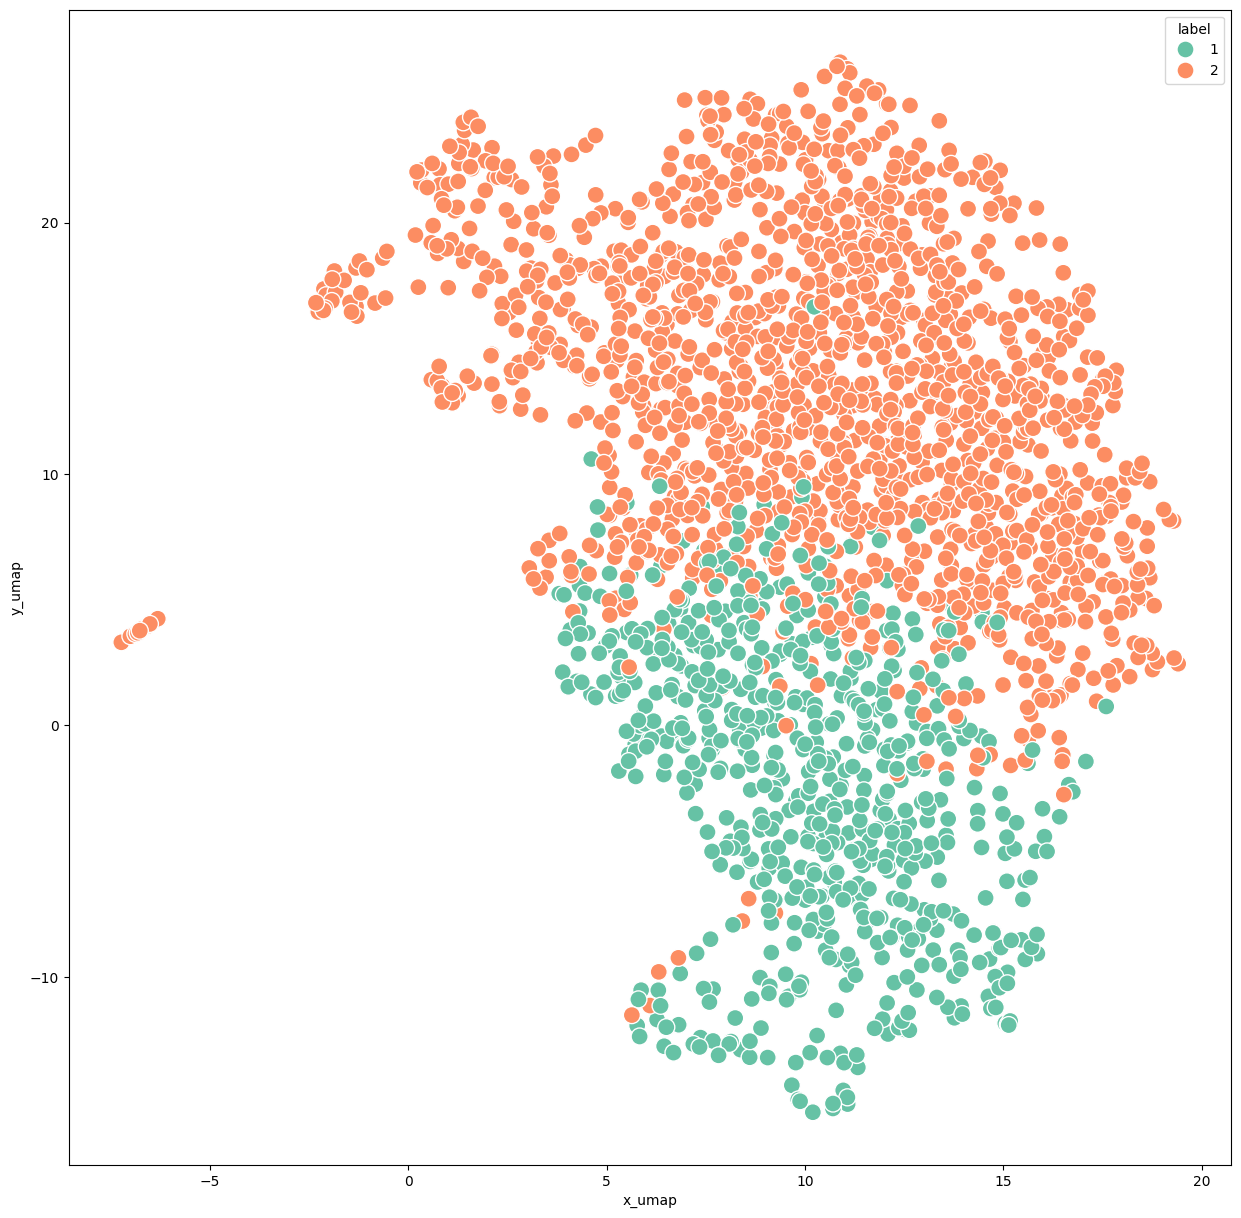

In [18]:
f, ax = plt.subplots(1,1,figsize=(15,15))
sns.scatterplot(data=show_df[show_df['region'].isin(order_list)], 
                x='x_umap', y='y_umap', hue='label',
                palette={1: '#66c2a5', 2: '#fc8d62', 
                         3: '#8da0cb', 4: '#e78ac3'},
                s=150
               )

plt.savefig('./lm_cluster_usingLM.svg', bbox_inches='tight')

In [19]:
show_df

,x_umap,y_umap,x_sp,y_sp,region,soma_x,soma_y,soma_z,label
SEU-ALLEN_local_15257_11828_9319_6464_CCFv3,16.210230,6.895874,-0.186924,0.906688,CA1,350.87900,119.023,382.147,2
SEU-ALLEN_local_15257_12664_10213_6561_CCFv3,-2.125170,17.360266,-6.324810,-1.563910,CA1,354.43500,104.924,368.520,2
SEU-ALLEN_local_15257_12696_10181_6599_CCFv3,-2.071168,17.108667,-5.620287,0.967823,CA1,356.41800,103.741,369.152,2
SEU-ALLEN_local_15257_12727_10075_6525_CCFv3,2.639445,13.833082,-2.389533,0.010166,CA1,352.20596,103.706,370.922,2
SEU-ALLEN_local_15257_12761_10139_6565_CCFv3,-1.859927,18.074007,-3.807943,2.311645,CA1,354.33900,102.760,369.913,2
...,...,...,...,...,...,...,...,...,...
SEU-ALLEN_local_211541_4871_9997_7102_CCFv3,11.051543,12.050756,-0.135219,-1.932351,CA1,352.39300,175.227,365.120,2
SEU-ALLEN_local_211541_5071_7478_6674_CCFv3,15.851976,-8.312741,4.718724,3.231417,CA1,328.62100,218.458,359.391,1
SEU-ALLEN_local_211541_5886_7004_6693_CCFv3,10.135291,-6.783165,3.948351,0.744738,CA1,326.03600,231.018,346.088,1
SEU-ALLEN_local_236174_15628_9151_6670_CCFv3,8.012023,-4.869641,3.022187,4.211979,CA1,324.80300,225.821,349.086,1


In [20]:
show_df['color'] = ''

show_df.loc[show_df['label'] == 1, 'color'] = list(sns.palettes.color_palette('Set2').as_hex())[0]
show_df.loc[show_df['label'] == 2, 'color'] = list(sns.palettes.color_palette('Set2').as_hex())[1]
# show_df.loc[show_df['label'] == 3, 'color'] = list(sns.palettes.color_palette('Set2').as_hex())[2]
# show_df.loc[show_df['label'] == 4, 'color'] = list(sns.palettes.color_palette('Set2').as_hex())[3]

In [21]:
show_df.to_csv('../../data/CA1_hippo_data.csv')
show_df

,x_umap,y_umap,x_sp,y_sp,region,soma_x,soma_y,soma_z,label,color
SEU-ALLEN_local_15257_11828_9319_6464_CCFv3,16.210230,6.895874,-0.186924,0.906688,CA1,350.87900,119.023,382.147,2,#fc8d62
SEU-ALLEN_local_15257_12664_10213_6561_CCFv3,-2.125170,17.360266,-6.324810,-1.563910,CA1,354.43500,104.924,368.520,2,#fc8d62
SEU-ALLEN_local_15257_12696_10181_6599_CCFv3,-2.071168,17.108667,-5.620287,0.967823,CA1,356.41800,103.741,369.152,2,#fc8d62
SEU-ALLEN_local_15257_12727_10075_6525_CCFv3,2.639445,13.833082,-2.389533,0.010166,CA1,352.20596,103.706,370.922,2,#fc8d62
SEU-ALLEN_local_15257_12761_10139_6565_CCFv3,-1.859927,18.074007,-3.807943,2.311645,CA1,354.33900,102.760,369.913,2,#fc8d62
...,...,...,...,...,...,...,...,...,...,...
SEU-ALLEN_local_211541_4871_9997_7102_CCFv3,11.051543,12.050756,-0.135219,-1.932351,CA1,352.39300,175.227,365.120,2,#fc8d62
SEU-ALLEN_local_211541_5071_7478_6674_CCFv3,15.851976,-8.312741,4.718724,3.231417,CA1,328.62100,218.458,359.391,1,#66c2a5
SEU-ALLEN_local_211541_5886_7004_6693_CCFv3,10.135291,-6.783165,3.948351,0.744738,CA1,326.03600,231.018,346.088,1,#66c2a5
SEU-ALLEN_local_236174_15628_9151_6670_CCFv3,8.012023,-4.869641,3.022187,4.211979,CA1,324.80300,225.821,349.086,1,#66c2a5


In [23]:
lm_feature = df.loc[soma_feature.index, 
        ['Number of Stems', 'Number of Branches', 'Total Length', 'Average Bifurcation Angle Local', 
         'Average Bifurcation Angle Remote', 'Hausdorff Dimension']
        ]

lm_feature['label'] = show_df.loc[lm_feature.index, 'label']
lm_feature

,Number of Stems,Number of Branches,Total Length,Average Bifurcation Angle Local,Average Bifurcation Angle Remote,Hausdorff Dimension,label
SEU-ALLEN_local_15257_11828_9319_6464_CCFv3,3,23,917.8650,41.6182,55.1676,1.028690,2
SEU-ALLEN_local_15257_12664_10213_6561_CCFv3,1,1,100.7750,58.9138,71.0169,0.983289,2
SEU-ALLEN_local_15257_12696_10181_6599_CCFv3,1,1,98.7448,58.9138,71.0169,0.985679,2
SEU-ALLEN_local_15257_12727_10075_6525_CCFv3,1,3,220.3980,43.8063,148.2260,1.040740,2
SEU-ALLEN_local_15257_12761_10139_6565_CCFv3,1,1,101.7160,58.9138,71.0169,0.967055,2
...,...,...,...,...,...,...,...
SEU-ALLEN_local_211541_4871_9997_7102_CCFv3,2,20,587.0170,55.0734,52.1330,1.075310,2
SEU-ALLEN_local_211541_5071_7478_6674_CCFv3,6,76,2790.9000,56.6715,55.4485,1.064470,1
SEU-ALLEN_local_211541_5886_7004_6693_CCFv3,4,78,2542.7700,66.8227,59.4150,1.145690,1
SEU-ALLEN_local_236174_15628_9151_6670_CCFv3,4,50,1903.8600,71.6669,73.3768,1.147920,1


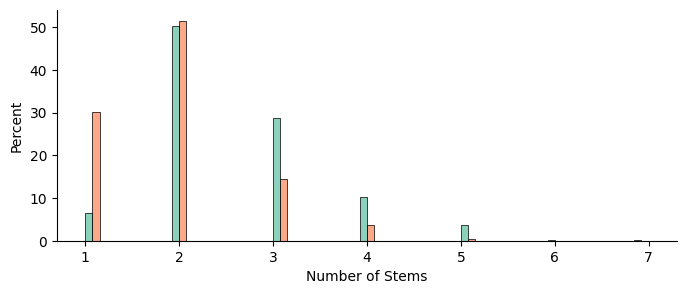

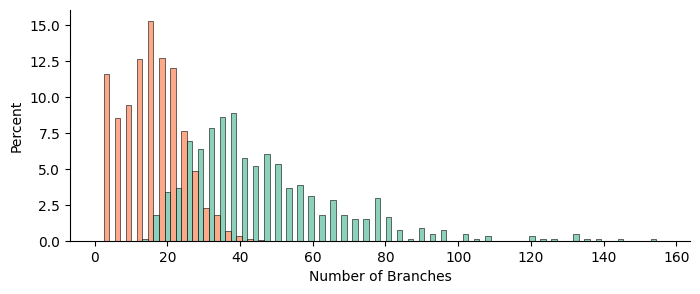

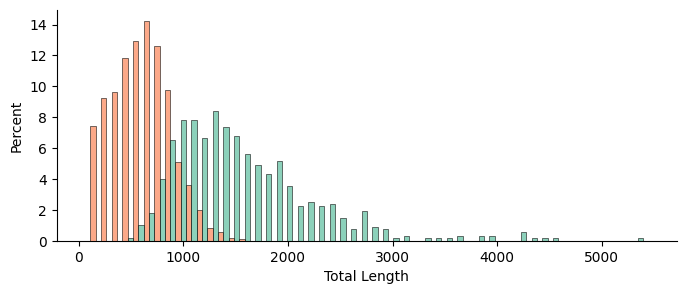

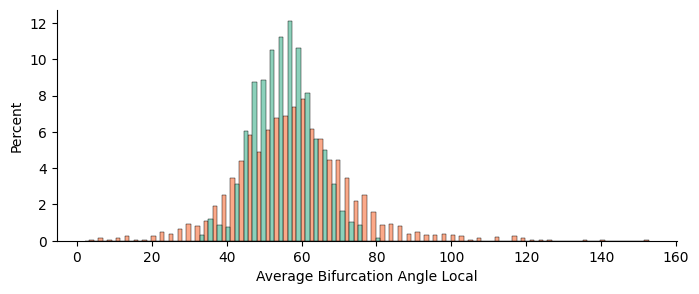

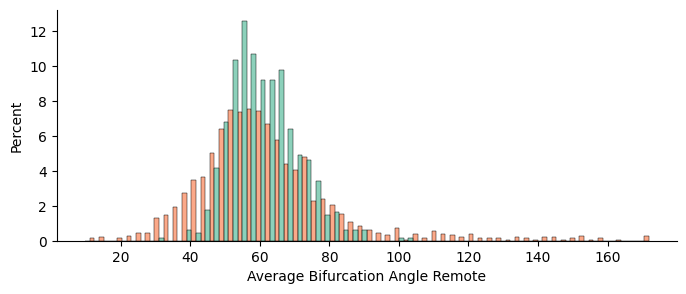

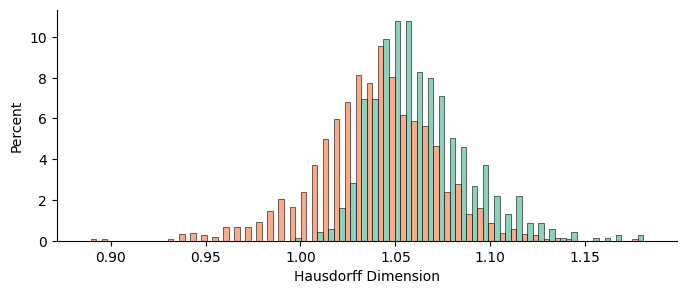

In [24]:
for i in ['Number of Stems', 'Number of Branches', 'Total Length', 'Average Bifurcation Angle Local', 
         'Average Bifurcation Angle Remote', 'Hausdorff Dimension']:
    tmp_df = lm_feature[[i, 'label']]
    f,ax = plt.subplots(1,1,figsize=(8,3))
    sns.histplot(data=tmp_df,x=i, hue='label', 
                 multiple='dodge',stat='percent',
                 common_norm=False,
                 palette=list(sns.palettes.color_palette('Set2').as_hex())[0:2],
                legend=False)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    if i == 'Total Length':
        f.savefig('./'+i+'_feature.svg', bbox_inches='tight')

In [25]:
show_df['label'].value_counts()

label
2    1509
1     676
Name: count, dtype: int64

In [26]:
show_df

,x_umap,y_umap,x_sp,y_sp,region,soma_x,soma_y,soma_z,label,color
SEU-ALLEN_local_15257_11828_9319_6464_CCFv3,16.210230,6.895874,-0.186924,0.906688,CA1,350.87900,119.023,382.147,2,#fc8d62
SEU-ALLEN_local_15257_12664_10213_6561_CCFv3,-2.125170,17.360266,-6.324810,-1.563910,CA1,354.43500,104.924,368.520,2,#fc8d62
SEU-ALLEN_local_15257_12696_10181_6599_CCFv3,-2.071168,17.108667,-5.620287,0.967823,CA1,356.41800,103.741,369.152,2,#fc8d62
SEU-ALLEN_local_15257_12727_10075_6525_CCFv3,2.639445,13.833082,-2.389533,0.010166,CA1,352.20596,103.706,370.922,2,#fc8d62
SEU-ALLEN_local_15257_12761_10139_6565_CCFv3,-1.859927,18.074007,-3.807943,2.311645,CA1,354.33900,102.760,369.913,2,#fc8d62
...,...,...,...,...,...,...,...,...,...,...
SEU-ALLEN_local_211541_4871_9997_7102_CCFv3,11.051543,12.050756,-0.135219,-1.932351,CA1,352.39300,175.227,365.120,2,#fc8d62
SEU-ALLEN_local_211541_5071_7478_6674_CCFv3,15.851976,-8.312741,4.718724,3.231417,CA1,328.62100,218.458,359.391,1,#66c2a5
SEU-ALLEN_local_211541_5886_7004_6693_CCFv3,10.135291,-6.783165,3.948351,0.744738,CA1,326.03600,231.018,346.088,1,#66c2a5
SEU-ALLEN_local_236174_15628_9151_6670_CCFv3,8.012023,-4.869641,3.022187,4.211979,CA1,324.80300,225.821,349.086,1,#66c2a5


In [27]:
all_cell['label'] = show_df.loc[all_cell.index, 'label']
all_cell

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,18,label
target_cell,,,,,,,,,,,,,,,,,,
SEU-ALLEN_local_15257_11828_9319_6464_CCFv3,62,302,93,170,0,0,0,0,0,0,0,0,0,0,0,0,0,2
SEU-ALLEN_local_15257_12664_10213_6561_CCFv3,73,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2
SEU-ALLEN_local_15257_12696_10181_6599_CCFv3,85,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2
SEU-ALLEN_local_15257_12727_10075_6525_CCFv3,21,128,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2
SEU-ALLEN_local_15257_12761_10139_6565_CCFv3,88,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SEU-ALLEN_local_211541_4871_9997_7102_CCFv3,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,2
SEU-ALLEN_local_211541_5071_7478_6674_CCFv3,0,50,114,62,49,23,51,38,6,18,0,0,0,0,0,0,0,1
SEU-ALLEN_local_211541_5886_7004_6693_CCFv3,0,0,16,20,0,0,10,0,0,0,0,0,0,0,0,0,0,1


In [28]:
all_counts = pd.DataFrame(all_cell.iloc[:, :-2].sum(axis=1), columns=['counts'])
all_counts['label'] = show_df.loc[all_counts.index, 'label']

all_counts

,counts,label
target_cell,,
SEU-ALLEN_local_15257_11828_9319_6464_CCFv3,627,2
SEU-ALLEN_local_15257_12664_10213_6561_CCFv3,73,2
SEU-ALLEN_local_15257_12696_10181_6599_CCFv3,85,2
SEU-ALLEN_local_15257_12727_10075_6525_CCFv3,149,2
SEU-ALLEN_local_15257_12761_10139_6565_CCFv3,88,2
...,...,...
SEU-ALLEN_local_211541_4871_9997_7102_CCFv3,1,2
SEU-ALLEN_local_211541_5071_7478_6674_CCFv3,411,1
SEU-ALLEN_local_211541_5886_7004_6693_CCFv3,46,1


1 mean:  493.96153846153845 
 2 mean:  155.08151093439363


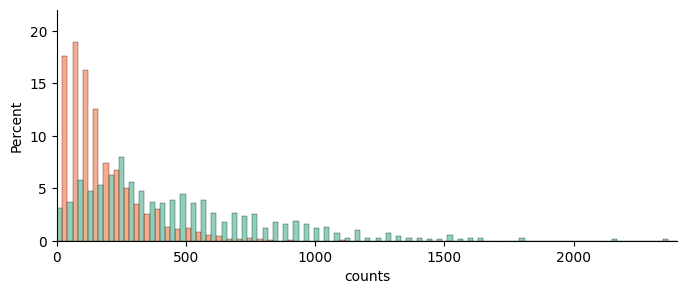

In [29]:
f, ax = plt.subplots(1,1,figsize=(8,3))
sns.histplot(data=all_counts, hue='label', 
            x='counts', stat='percent',
             common_norm=False,
             multiple='dodge',
             palette={1: '#66c2a5', 2: '#fc8d62'},
             legend=False
           )
print('1 mean: ', np.mean(all_counts.loc[all_counts['label']==1, 'counts']),
      '\n', 
      '2 mean: ', np.mean(all_counts.loc[all_counts['label']==2, 'counts']),
     )
plt.xlim([0, 2400])
plt.ylim([0, 22])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.savefig('./spine_counts_cluster.svg', bbox_inches='tight')

In [30]:
wide_df = all_cell[[str(1+i) for i in range(10)]+['label']].groupby('label').mean()
wide_df = (wide_df.T / wide_df.sum(axis=1)).T
wide_df

,1,2,3,4,5,6,7,8,9,10
label,,,,,,,,,,
1,0.02441,0.069056,0.125181,0.185429,0.191053,0.160912,0.112768,0.073388,0.038325,0.019478
2,0.05891,0.158078,0.213266,0.239892,0.187225,0.093275,0.034467,0.012208,0.002513,0.000167


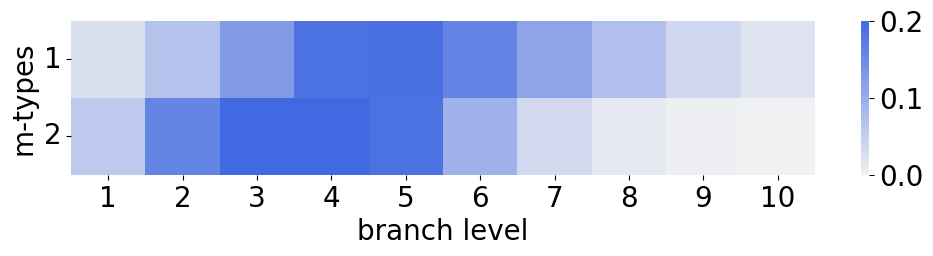

In [32]:
f,ax = plt.subplots(1,1,figsize=(12,2))
sns.heatmap(wide_df, 
            vmin=0, vmax=0.2,
            cmap=sns.color_palette("light:royalblue", as_cmap=True),
            # vmax=0.3
           )
cb = ax.collections[0].colorbar
cb.ax.tick_params(labelsize=20)

ax.set_xlabel('branch level', fontsize=20)
ax.set_ylabel('m-types', fontsize=20)

ax.set_xticks(np.arange(0,len(wide_df.columns))+0.5, 
              list(range(1,len(wide_df.columns)+1)), 
              fontsize=20)

ax.set_yticks(np.arange(0,len(wide_df.index))+0.5, 
              wide_df.index, fontsize=20, rotation=0)
plt.savefig('./mtype_branch_level.svg', dpi=400, bbox_inches='tight')
plt.show()